In [21]:
import os
import numpy as np
from dotenv import load_dotenv
import pandas as pd


load_dotenv()
hf_token = os.getenv("HF_TOKEN")

In [22]:
df_gemma = pd.read_parquet("../data/gemma_att_kl_0_7000_df.parquet")
df_cnn = pd.read_parquet("../data/cnn_att_kl_0_1000_df.parquet")
df_xsum = pd.read_parquet("../data/xsum_kl_0_1000_df.parquet")

In [23]:
# df_gemma = pd.DataFrame()

# for file in os.listdir("../"):
#     if file.startswith("gemma_att_diff_mean") and file.endswith(".parquet"):
#         df_gemma = pd.concat([df_gemma, pd.read_parquet(f"../{file}")])

# df_gemma.to_parquet("../data/gemma_att_diff_df.parquet")
# df_gemma.shape

In [24]:
# df_cnn = pd.DataFrame()

# for file in os.listdir("../"):
#     if file.startswith("cnn_att_diff_mean") and file.endswith(".parquet"):
#         df_cnn = pd.concat([df_cnn, pd.read_parquet(f"../{file}")])

# df_cnn.to_parquet("../data/cnn_att_diff_df.parquet")
# df_cnn.shape

In [25]:
# from ydata_profiling import ProfileReport

# df_gemma_eda = df_gemma.drop(['dataset'], axis=1)
# # Create a profile report
# profile = ProfileReport(
#     df_gemma_eda, 
#     title="Gemma DataFrame Profiling Report",
#     correlations={
#         "chi_squared": {"calculate": False},
#     }

# )
# # To display the report in a Jupyter Notebook
# profile.to_notebook_iframe()

In [26]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

In [27]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import IsolationForest
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler


datasets = [
    # {
    #     "train_name": "xsum_cnn",
    #     "train": df_xsum,
    #     "test": df_cnn
    # },
    # {
    #     "train_name": "cnn_xsum",
    #     "train": df_cnn,
    #     "test": df_xsum
    # },
    # {
    #     "train_name": "gemma_xsum",
    #     "train": df_gemma,
    #     "test": df_xsum
    # },
    {
        "train_name": "gemma_cnn",
        "train": df_gemma,
        "test": df_cnn
    },
    {
        "train_name": "cnn_gemma",
        "train": df_cnn,
        "test": df_gemma
    }
]

results = []

for dataset in datasets:
    # kfold validation over the dataset
    df_train = dataset['train']
    df_test = dataset['test']

    X_train = df_train.drop(columns=['label', 'dataset'])
    y_train = df_train['label']

    X_test = df_test.drop(columns=['label', 'dataset'])
    y_test = df_test['label']

    models = {
        'LogisticRegression': LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42),
        # 'LGBMClassifier': LGBMClassifier(
        #     n_estimators=50,
        #     learning_rate=0.001,
        #     max_depth=10,
        #     num_leaves=15,
        #     class_weight='balanced',
        #     reg_alpha=0.1,
        #     reg_lambda=0.1,
        #     random_state=42,
        #     n_jobs=-1,
        #     silent=True,
        #     verbose=-1
        # )
    }

    for model_name, model in models.items():

        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Scale the data
            ('undersampler', RandomUnderSampler(random_state=42)),  # Undersample the majority class
            ('model', model)  # Fit the model
        ])
        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]


        results.append({
            'dataset': dataset['train_name'],
            'model': model_name,
            'train_auc': roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1]),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        })

test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


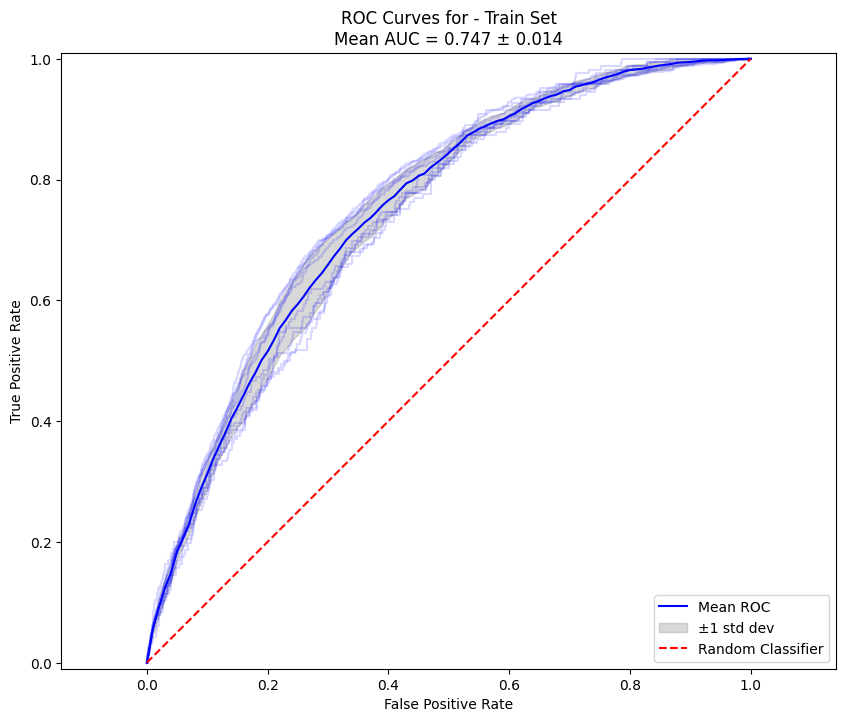

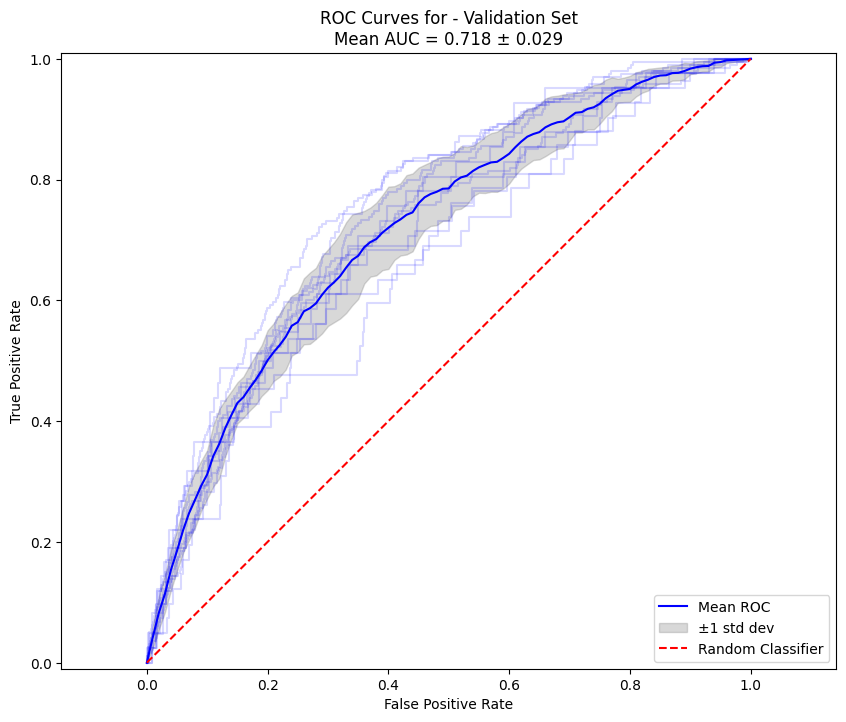

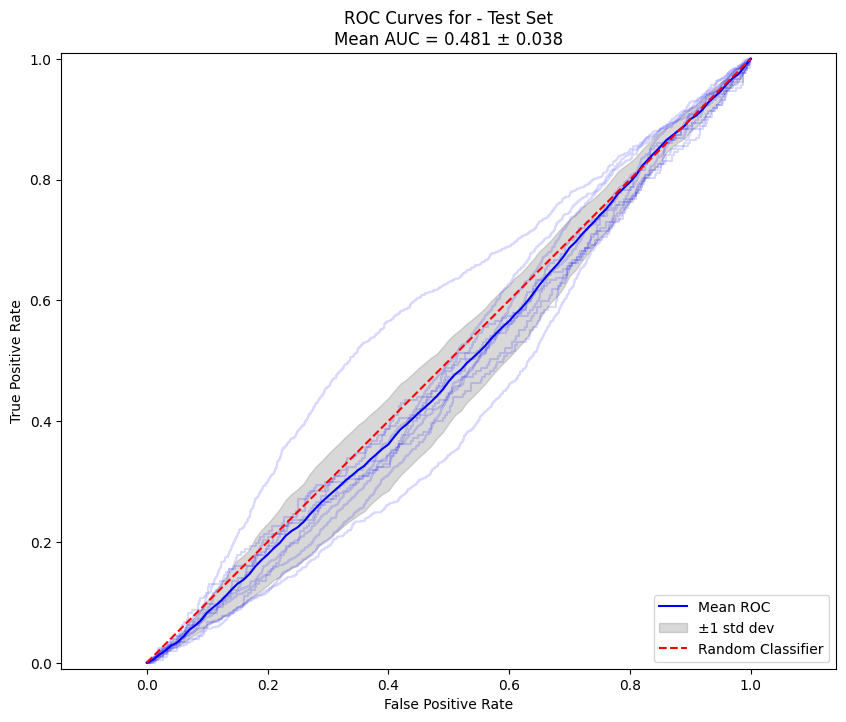

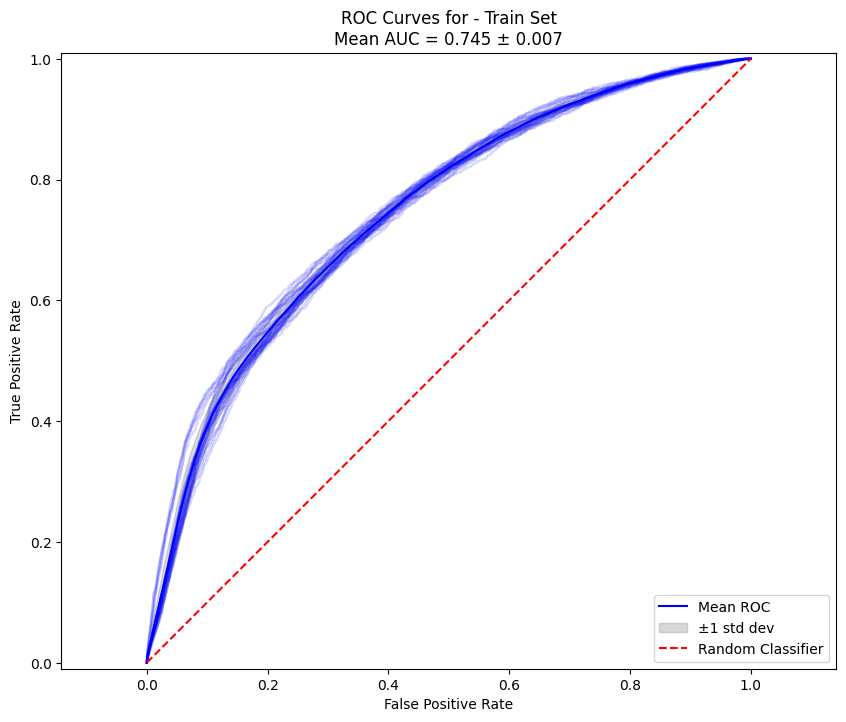

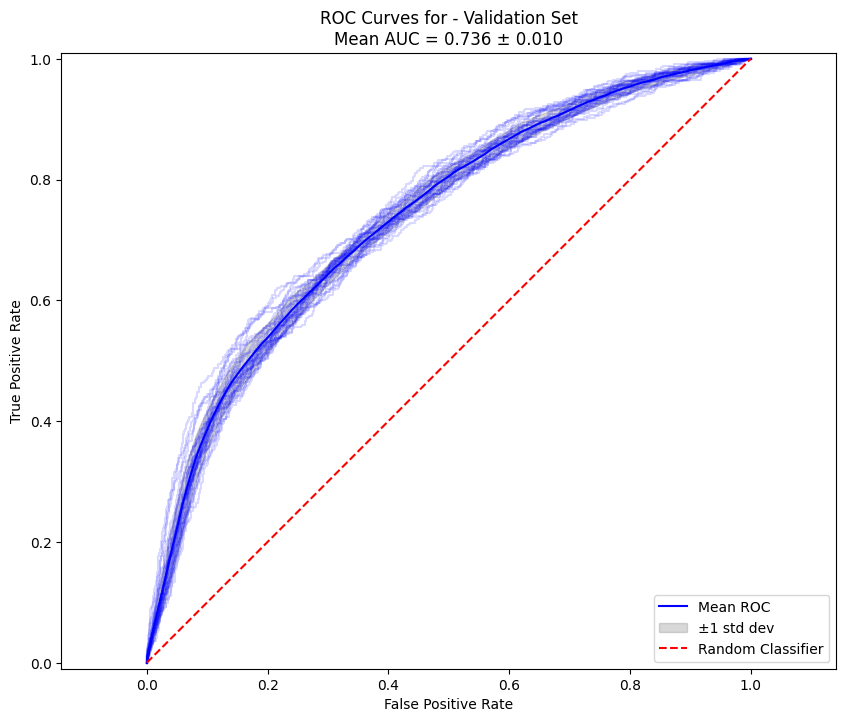

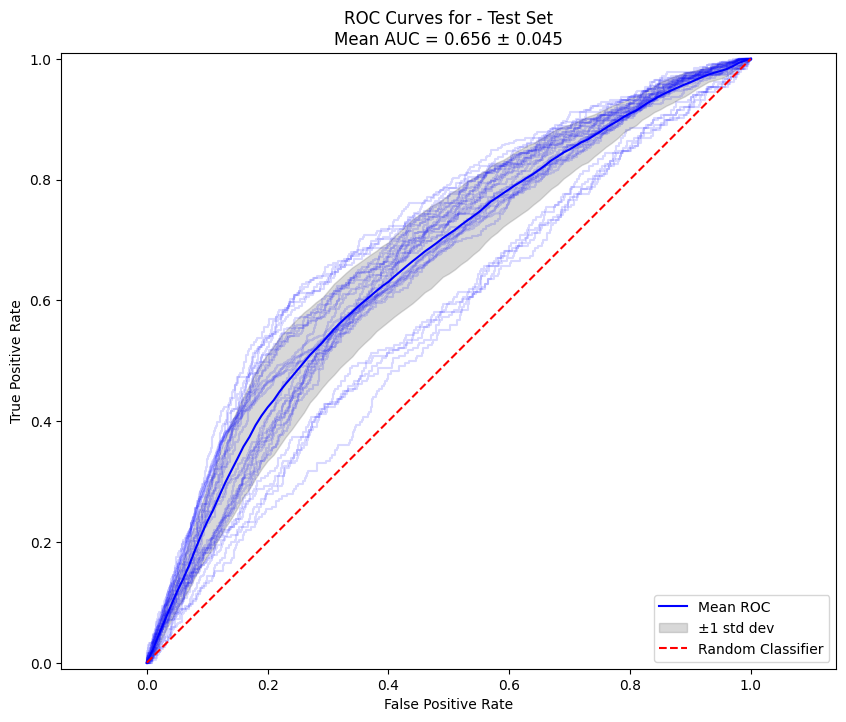

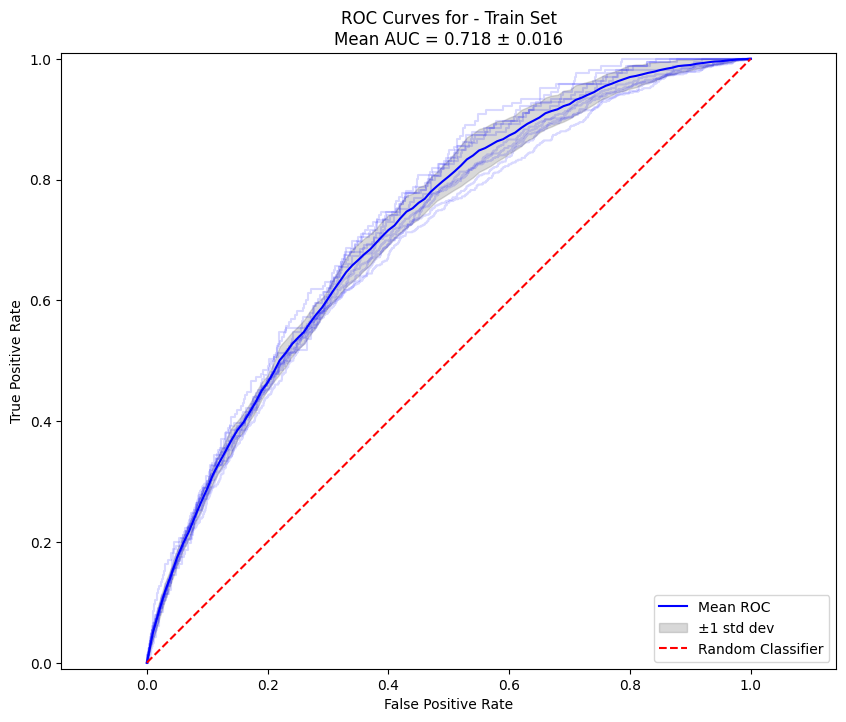

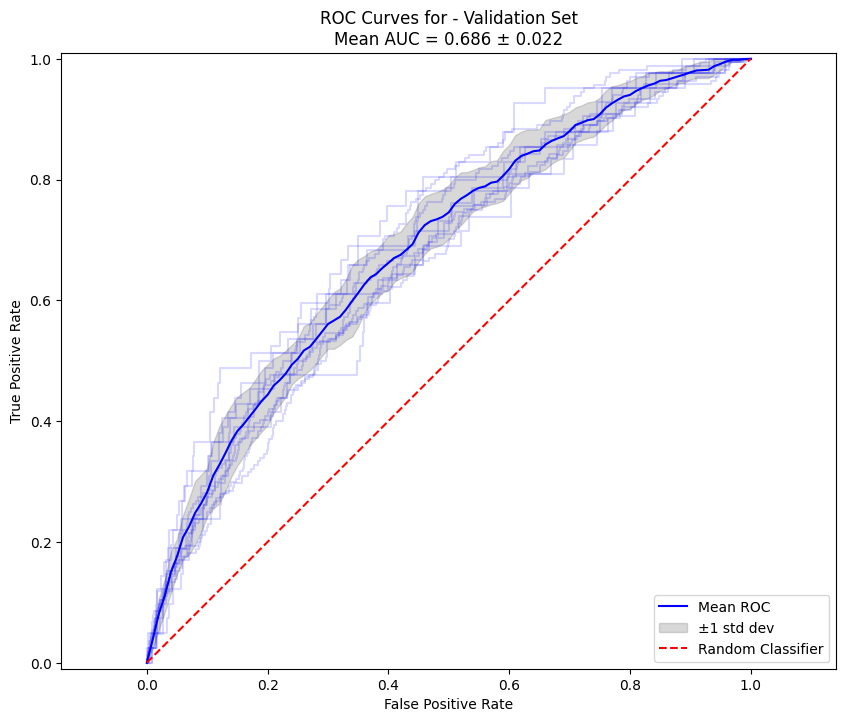

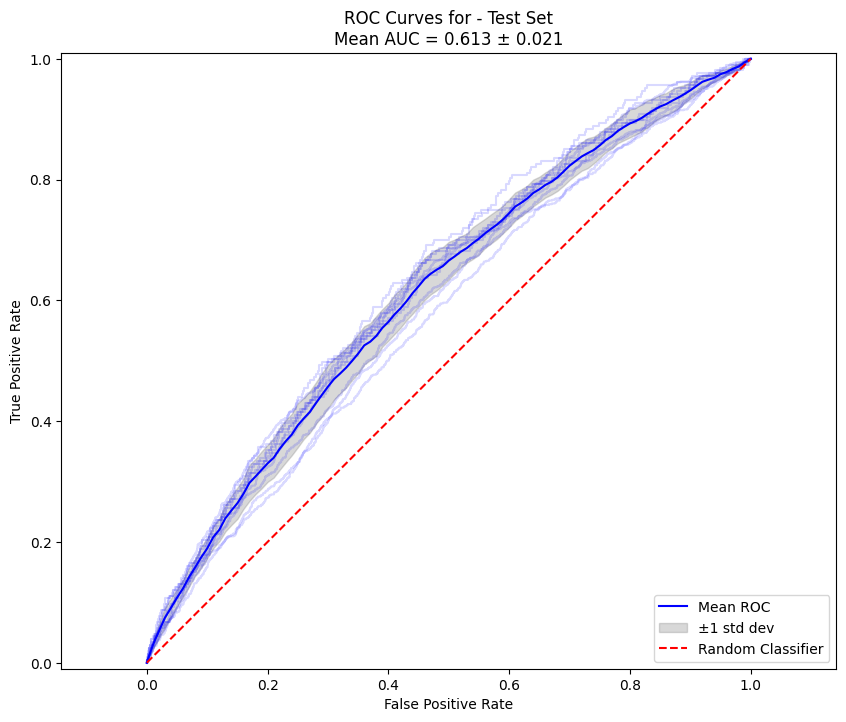

In [28]:
from golemai.ml.wandb_trainer import WandbTrainer

trainer = WandbTrainer(
    project_name="hallu-sklearn",
)

df_all = pd.concat([df_gemma, df_cnn, df_xsum])


trainer.evaluate(
    pipeline,
    df_all,
    group_name="kl_divergence",
    description="Test of kl divergence on all datasets",
)


In [29]:
# import torch
# from torch import nn
# from torch.utils.data import DataLoader, Dataset
# import lightning as L
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from torchmetrics.classification import AUROC
# from lightning.pytorch.callbacks import EarlyStopping

# # 1. Create a Synthetic Dataset
# class CustomDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# # 2. Define the LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
#         super().__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.hidden_dim = hidden_dim

#     def forward(self, x):
#         x = x.unsqueeze(1)  # (batch_size, seq_len, input_dim)
#         _, (hn, _) = self.lstm(x)  # hn is (num_layers, batch_size, hidden_dim)
#         out = self.fc(hn[-1])  # Use the last layer's hidden state
#         return out

# # 3. Create the Lightning Module
# class LSTMClassifier(L.LightningModule):
#     def __init__(self, input_dim, hidden_dim, output_dim, lr=5e-4, num_layers=1):
#         super().__init__()
#         self.model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers=num_layers)
#         self.criterion = nn.CrossEntropyLoss()
#         self.lr = lr

#         # AUROC metric for binary classification
#         self.train_auc = AUROC(task="binary")
#         self.val_auc = AUROC(task="binary")

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         data, labels = batch
#         preds = self(data)
#         loss = self.criterion(preds, labels)
#         # Calculate AUC during training
#         prob = torch.softmax(preds, dim=1)[:, 1]  # Take probabilities for class 1
#         auc = self.train_auc(prob, labels)
#         self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_auc", auc, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         data, labels = batch
#         preds = self(data)
#         loss = self.criterion(preds, labels)
#         # Calculate AUC during validation
#         prob = torch.softmax(preds, dim=1)[:, 1]  # Take probabilities for class 1
#         auc = self.val_auc(prob, labels)
#         self.log("val_loss", loss, prog_bar=True)
#         self.log("val_auc", auc, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr)




In [30]:
# from sklearn.preprocessing import RobustScaler


# X_train = df_gemma.drop(columns=['label', 'dataset'])
# y_train = df_gemma['label']

# X_val = df_cnn.drop(columns=['label', 'dataset'])
# y_val = df_cnn['label']

# scaler = RobustScaler()

# X_train_normalized = scaler.fit_transform(X_train)

# X_val_normalized = scaler.transform(X_val)

# train_dataset = CustomDataset(X_train_normalized, y_train)
# val_dataset = CustomDataset(X_val_normalized, y_val)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# # 4. Train the Model
# input_dim = X_train.shape[1]
# hidden_dim = 512
# output_dim = 2


# model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, lr=5e-4, num_layers=3)

# # 1. Set up EarlyStopping callback
# early_stop_callback = EarlyStopping(
#     monitor="val_loss",  # The metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will stop
#     verbose=True,        # Display a message when stopping
#     mode="min",          # Minimize the monitored metric (for loss)
# )

# # 2. Initialize the Trainer with the early stopping callback
# trainer = L.Trainer(
#     max_epochs=100,
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     log_every_n_steps=10,
#     callbacks=[early_stop_callback],  # Add the early stopping callback here
# )

# # 3. Start the training
# trainer.fit(model, train_loader, val_loader)

